In [2]:
import typing as tp

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import csv
import gzip
import os
import scipy.io
import cosg as cosg

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


Negative DNA probe count % : 0.010355047139532973
Negative decoding count % : 0.011608847441833181
Total number of genes: 480
Total number of cells: 129751


/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

Computing PCA...
Generating a kNN graph...


/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/umap/distances.py:108

Calculating UMAP...
Defining clusters...


/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


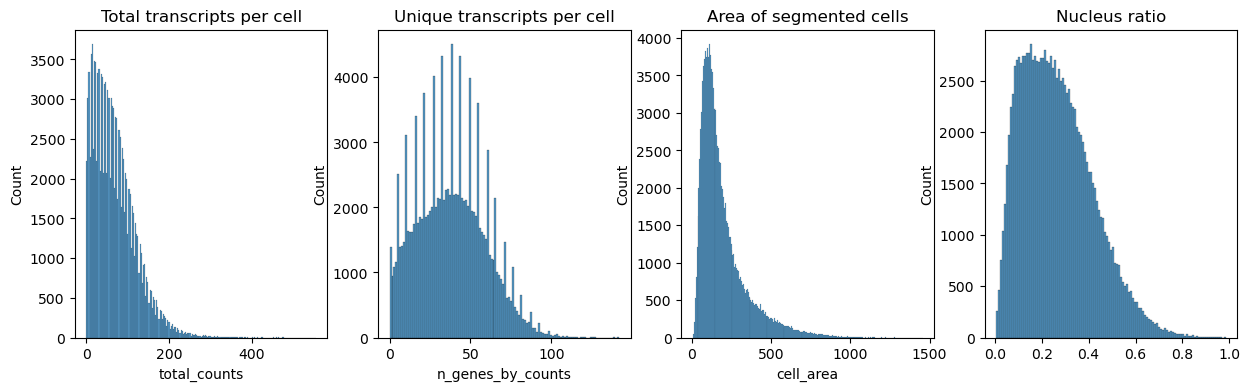

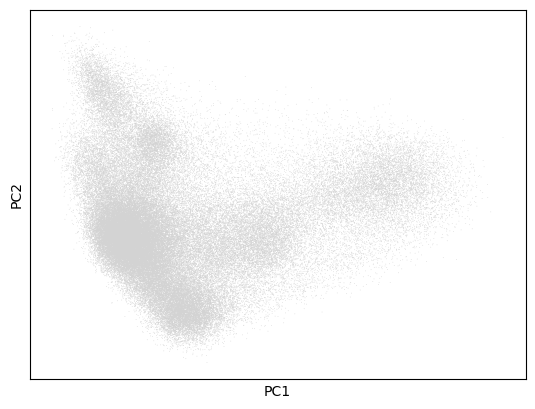

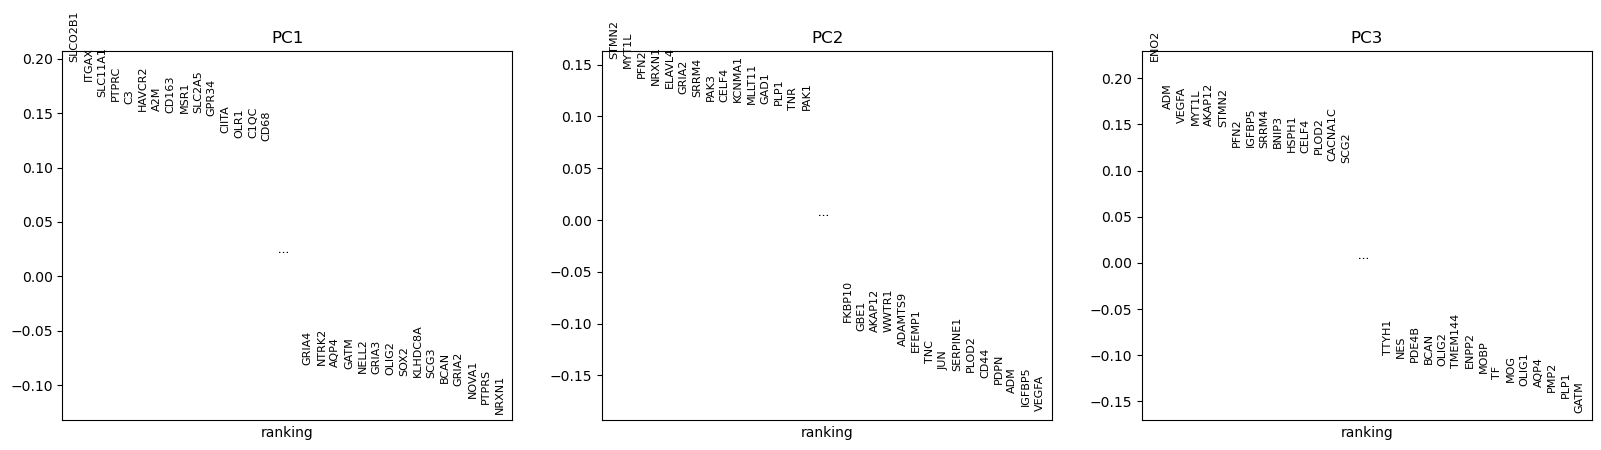

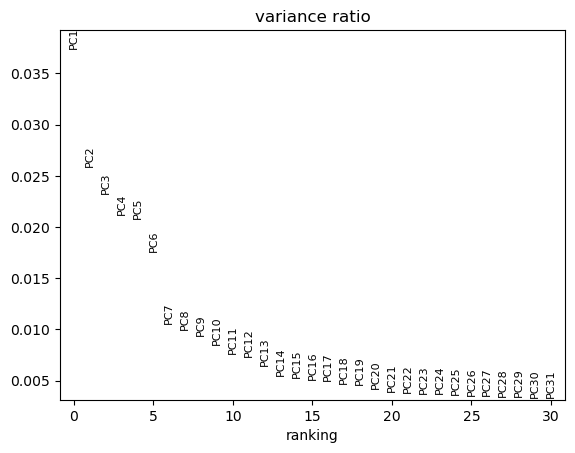

In [3]:
x="GB1"

adata = sc.read_10x_mtx(
    path="/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Xenium/Processed_data/GB_Visium_CytAssist/20240131_GB_CytAssist_Run02/"+x+"/nuclei_mtx"
)
df = pd.read_csv(
    "/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Xenium/Processed_data/GB_Visium_CytAssist/20240131_GB_CytAssist_Run02/"+x+"/nuclei.csv"
)
ci=adata.obs_names.tolist()
ci=[w[5:16] for w in ci]
df=df[df['cell_id'].isin(ci)]
df.set_index(adata.obs_names, inplace=True)
adata.obs = df.copy()
adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

sc.pp.calculate_qc_metrics(adata, percent_top=(10, 20, 50, 150), inplace=True)
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes}")
print(f"Negative decoding count % : {cwords}")
print(f"Total number of genes: {adata.n_vars}")
print(f"Total number of cells: {adata.n_obs}")
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)

sc.pp.filter_cells(adata, min_counts=30)
sc.pp.filter_genes(adata, min_cells=20)


adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
adata.layers['lognorm'] = adata.X.copy()
sc.pp.scale(adata, max_value=10)
print("Computing PCA...")
sc.pp.pca(adata)
print("Generating a kNN graph...")
sc.pp.neighbors(adata)
print("Calculating UMAP...")
sc.tl.umap(adata)
print("Defining clusters...")
sc.tl.leiden(adata)
sc.pl.pca_overview(adata)
adata.write(filename="/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/"+x+"/"+x+".h5ad", compression=None, compression_opts=None, as_dense=())

In [4]:
x="GB1"
adata=sc.read_h5ad(filename="/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/"+x+"/"+x+".h5ad")

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


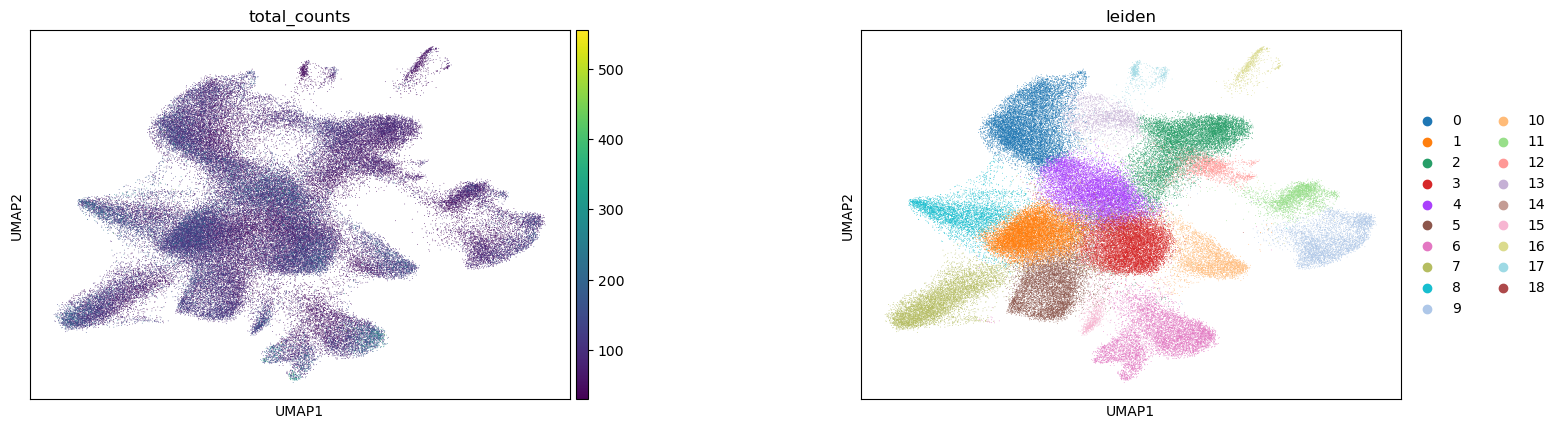

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  values_df = self.obs_tidy.groupby(level=0).mean()


categories: 0, 1, 2, etc.
var_group_labels: AC-like, AKT pathway, Angiogenesis, etc.


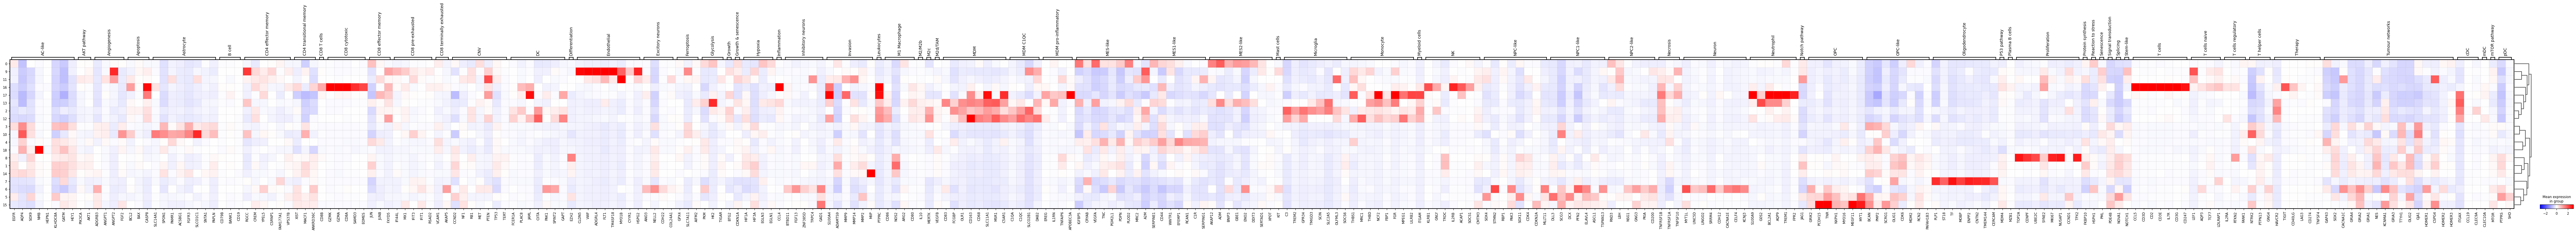

In [5]:
# sc.tl.leiden(adata, resolution=1.)

sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "leiden"
    ],
    wspace=0.4,
)
Panel=pd.read_csv("/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Combined_Analysis/xenium/Xenium_Panel_ZS.csv")
Panel=Panel[["gene", "final annotation"]]
genes = pd.DataFrame(adata.var_names, columns=["gene"])
Panel=pd.merge(Panel, genes, on=["gene"])
Annot=Panel.groupby('final annotation')['gene'].apply(list).to_dict()#(lambda x:x)
gs = sc.pl.matrixplot(adata, Annot, groupby='leiden', dendrogram=True,
                      use_raw=False, vmin=-3, vmax=3, cmap='bwr')

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:650: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(color_source_vector):


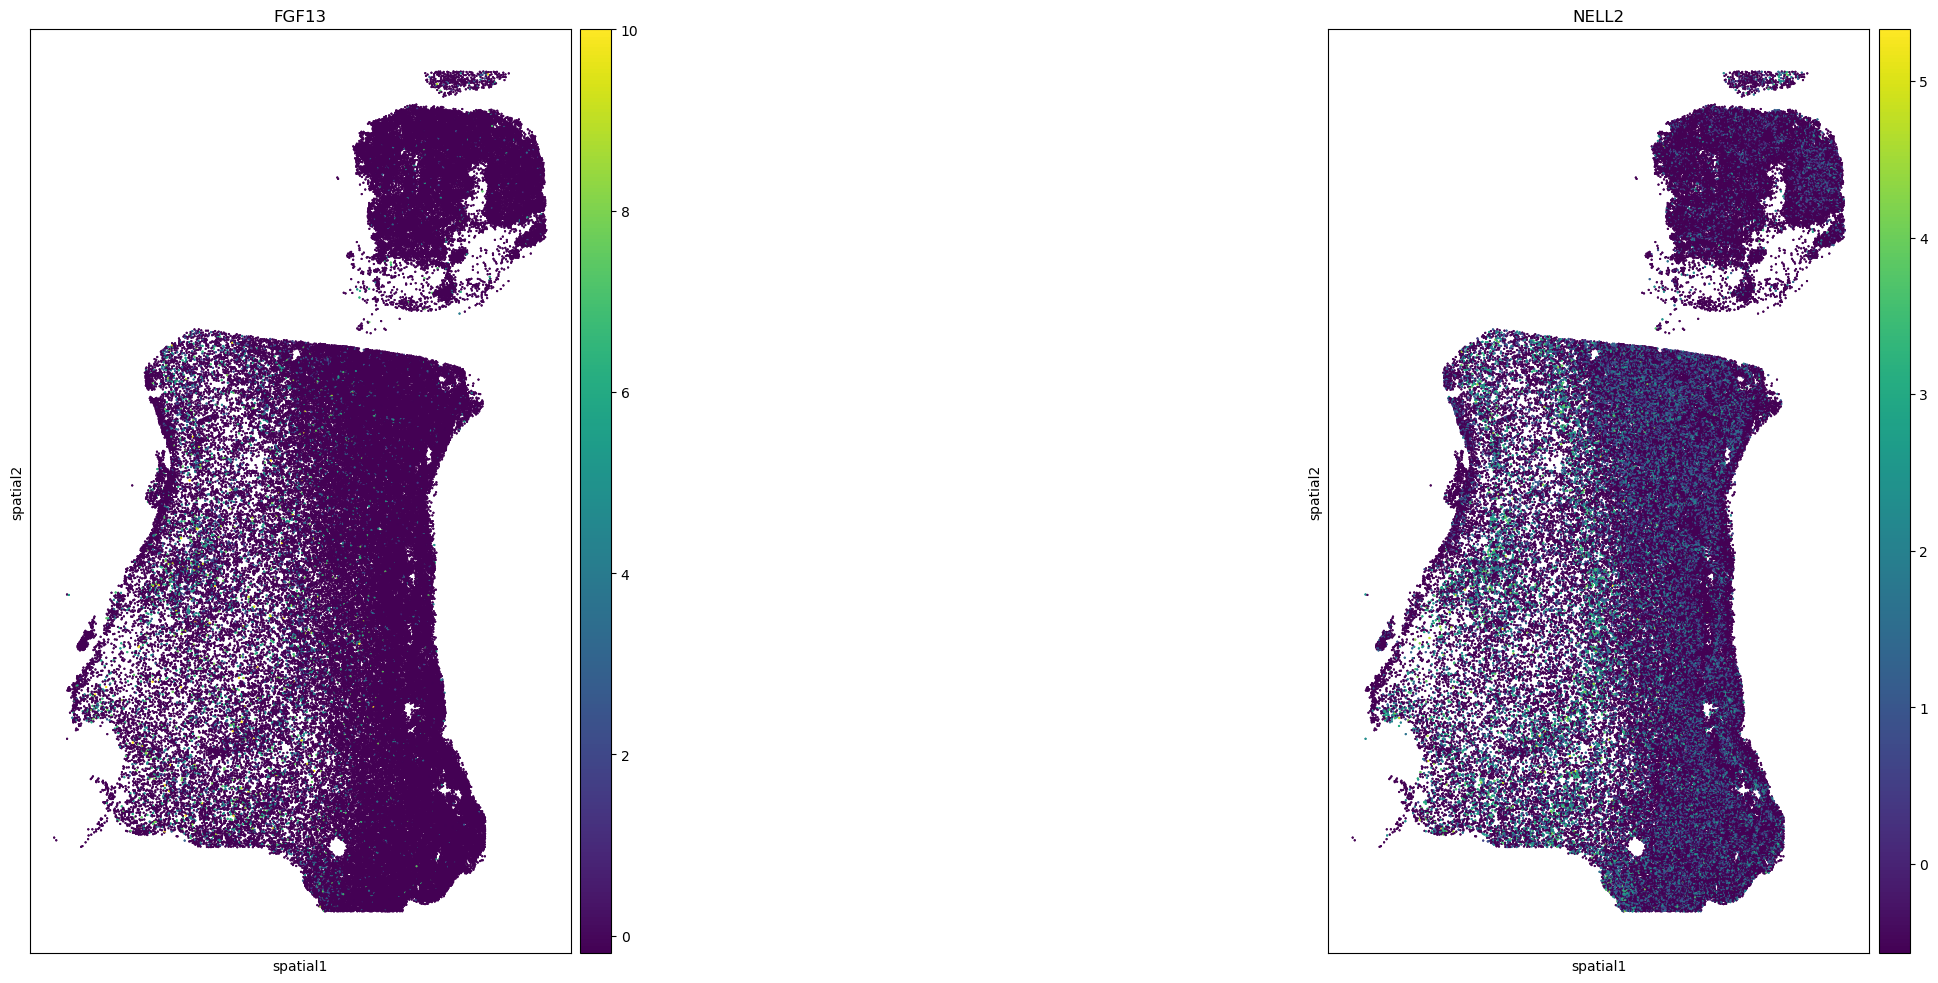

In [7]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        'FGF13',
        'NELL2'
    ],
    wspace=0.4,
    figsize=(10, 12)
)

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWa

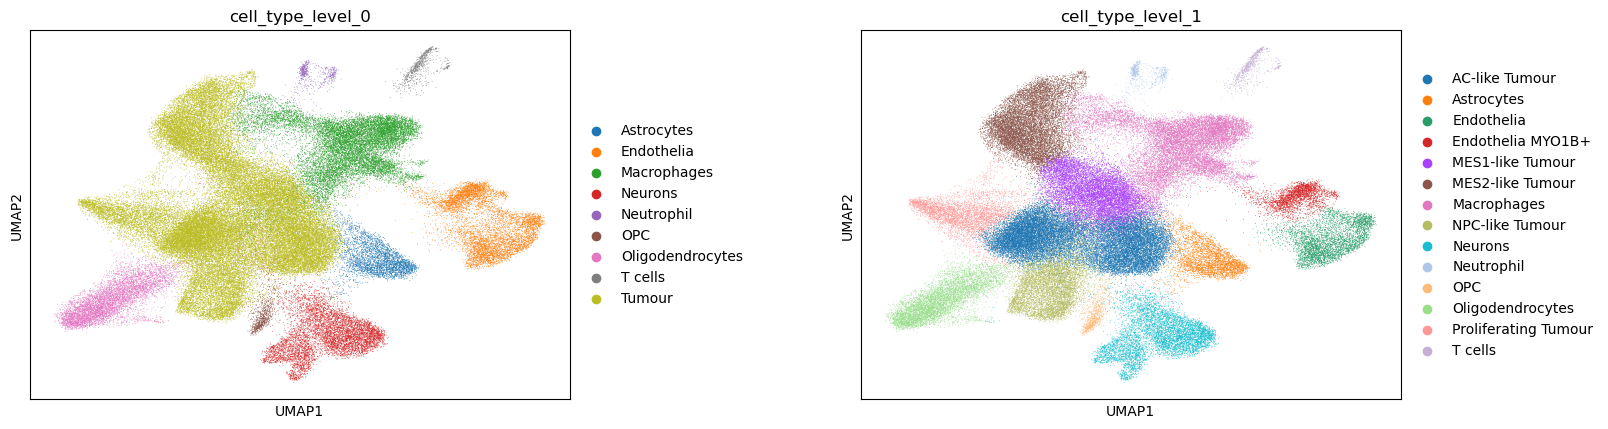

In [6]:
cell_types_1 = {
    '0': 'MES2-like Tumour',
    '1': 'AC-like Tumour',
    '2': 'Macrophages',
    '3': 'AC-like Tumour',
    '4': 'MES1-like Tumour',
    '5': 'NPC-like Tumour',
    '6': 'Neurons',
    '7': 'Oligodendrocytes',
    '8': 'Proliferating Tumour',
    '9': 'Endothelia',
    '10': 'Astrocytes',
    '11': 'Endothelia MYO1B+',
    '12': 'Macrophages',
    '13': 'Macrophages',
    '14': 'AC-like Tumour',
    '15': 'OPC',
    '16': 'T cells',
    '17': 'Neutrophil',
    '18': 'MES1-like Tumour'
}

cell_types_0 = {
    '0': 'Tumour',
    '1': 'Tumour',
    '2': 'Macrophages',
    '3': 'Tumour',
    '4': 'Tumour',
    '5': 'Tumour',
    '6': 'Neurons',
    '7': 'Oligodendrocytes',
    '8': 'Tumour',
    '9': 'Endothelia',
    '10': 'Astrocytes',
    '11': 'Endothelia',
    '12': 'Macrophages',
    '13': 'Macrophages',
    '14': 'Tumour',
    '15': 'OPC',
    '16': 'T cells',
    '17': 'Neutrophil',
    '18': 'Tumour'
}

adata.obs['cell_type_level_1'] = adata.obs['leiden'].map(cell_types_1)
adata.obs['cell_type_level_0'] = adata.obs['leiden'].map(cell_types_0)
sc.pl.umap(
    adata,
    color=[
        'cell_type_level_1'
    ],
    wspace=0.4,
)
adata.obs['cell_type_level_1'] = adata.obs['leiden'].map(cell_types_1)
adata.obs['cell_type_level_0'] = adata.obs['leiden'].map(cell_types_0)
sc.pl.umap(
    adata,
    color=[
        'cell_type_level_0',
    ],
    wspace=0.4,
    save=x+'_UMAP_cell_types.pdf'
)
adata.write(filename="/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/"+x+"/"+x+".h5ad", compression=None, compression_opts=None, as_dense=())

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


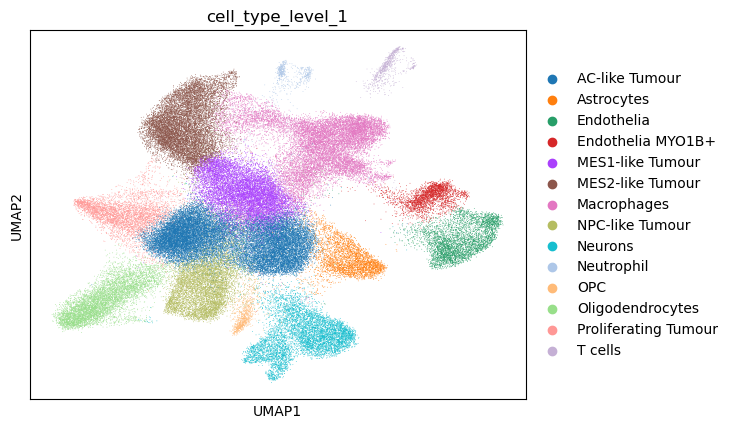

In [4]:
os.chdir("/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/"+x)
sc.pl.umap(
    adata,
    color=[
        'cell_type_level_1',
    ],
    wspace=0.4,
    save=x+'_UMAP_cell_types.pdf'
)

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:744: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(color_source_vector):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:650: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstanc

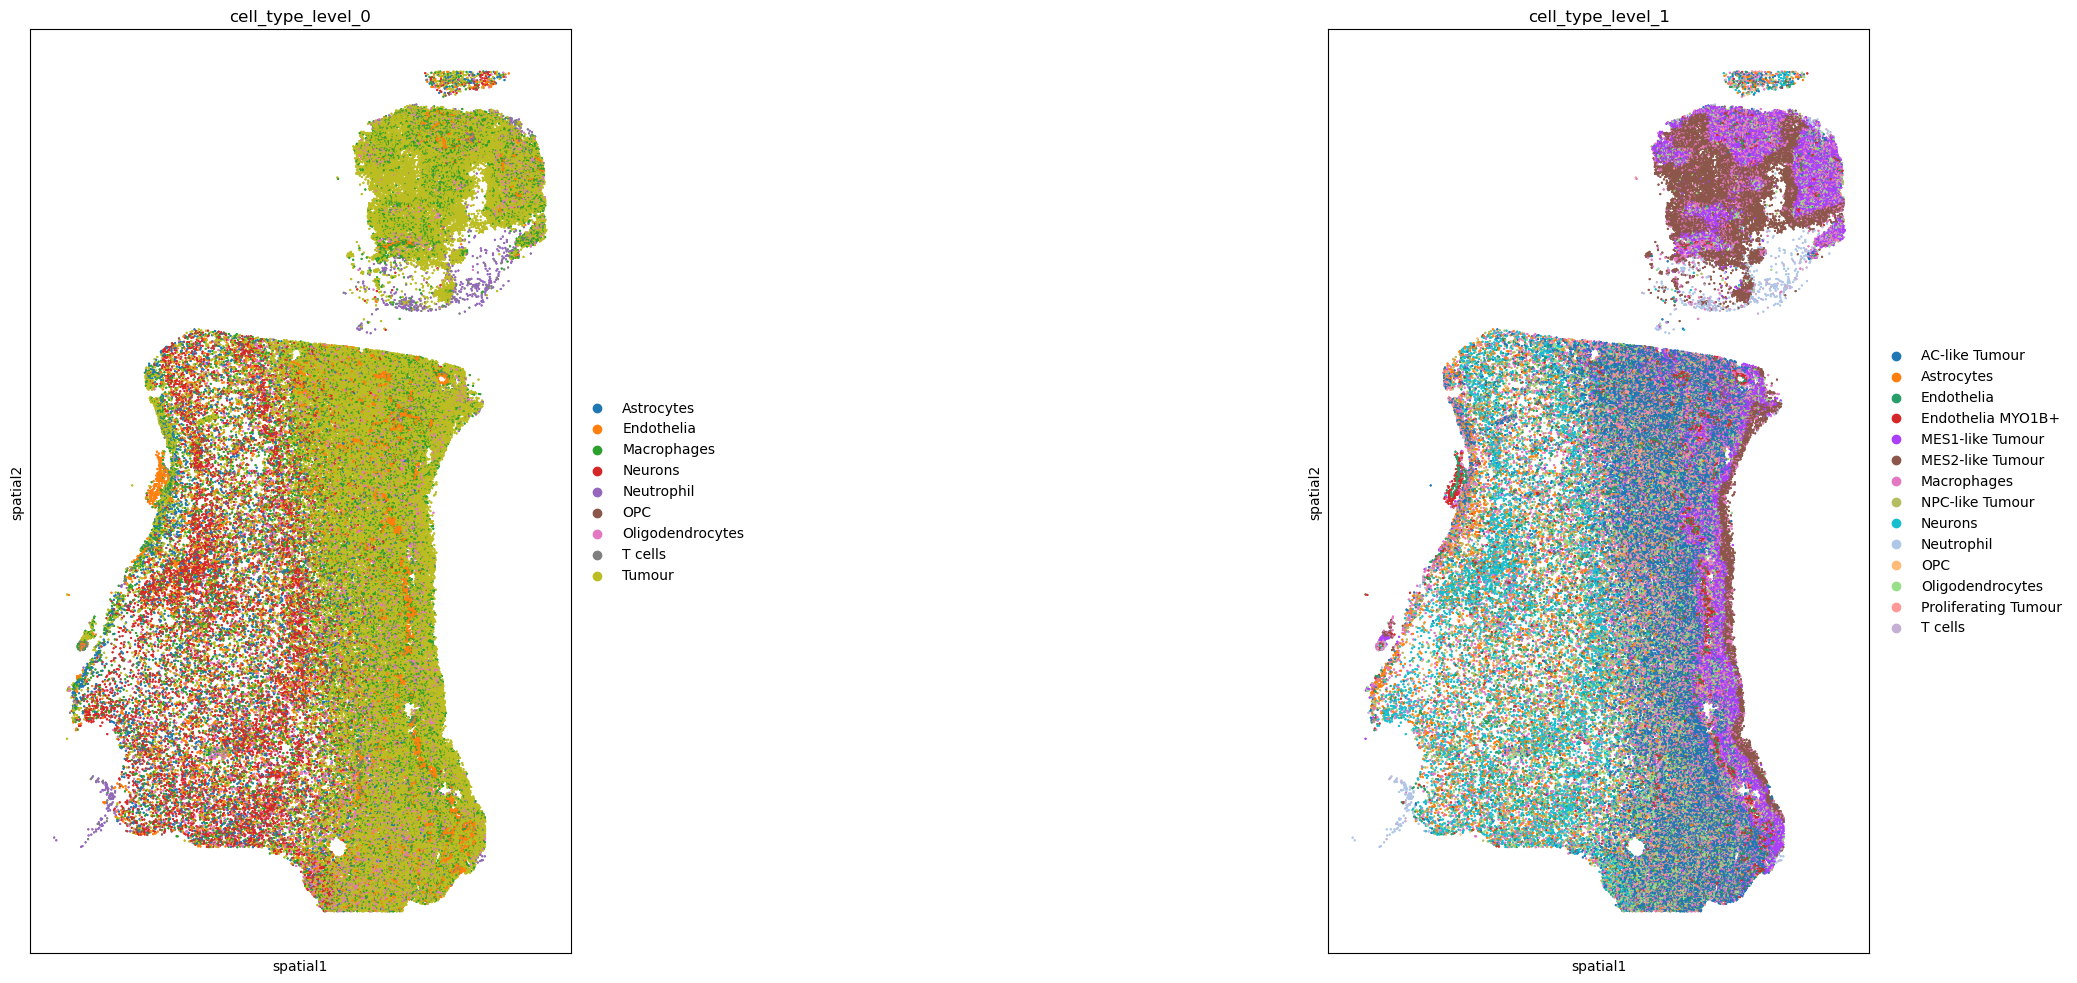

In [2]:
x="GB1"
adata=sc.read(filename="/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/"+x+"/"+x+".h5ad")
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        'cell_type_level_0',
        'cell_type_level_1',
    ],
    wspace=0.4,
    figsize=(10, 12)
)
plt.savefig('/omics/odcf/analysis/OE0146_projects/singlecell-and-spatialseq/Micha/Xenium_Analysis/'+x+'/'+x+'_spatial_cell_types.pdf') 

/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:744: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if c is not None and c in adata.obs and is_categorical_dtype(adata.obs[c]):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:390: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if key not in adata.obs or not is_categorical_dtype(adata.obs[key]):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/m510r/.conda/envs/xenium/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:472: FutureWarning: is_cate

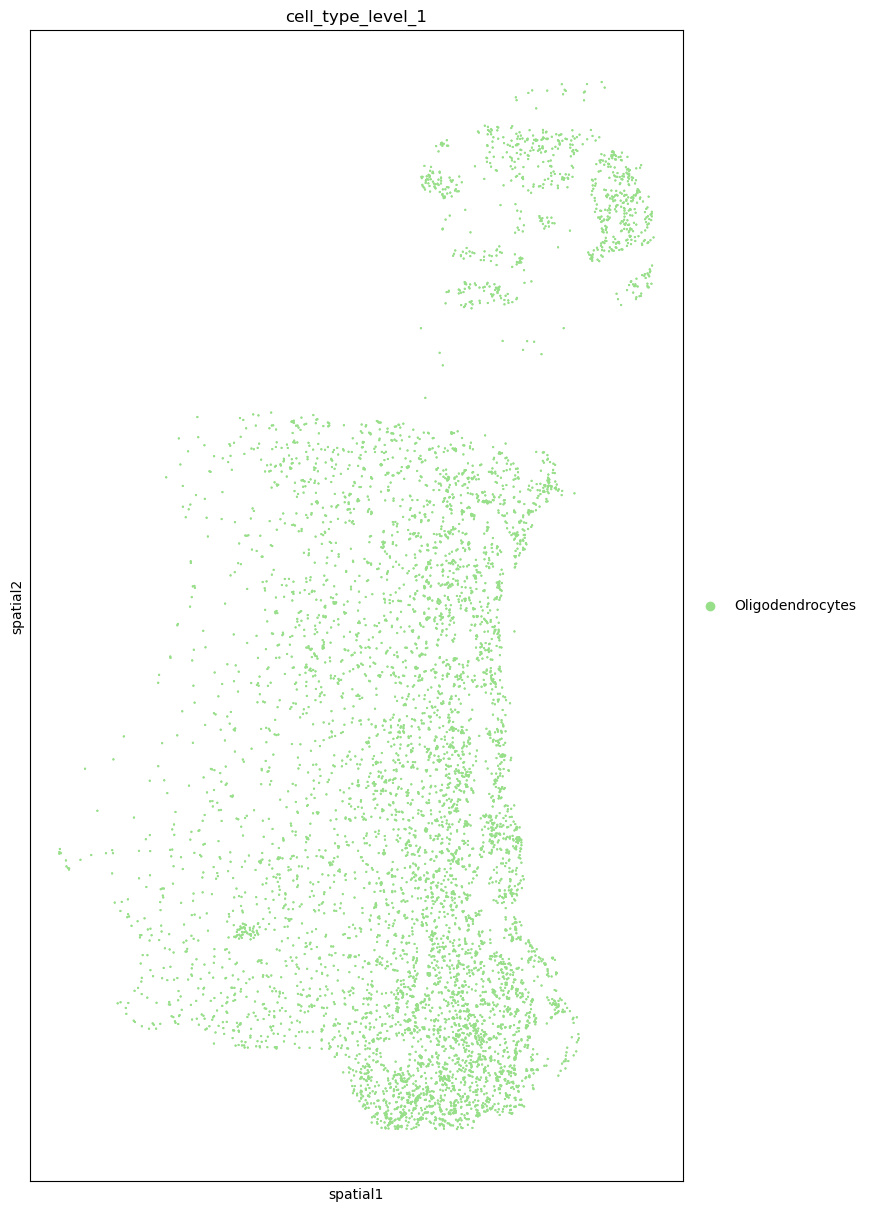

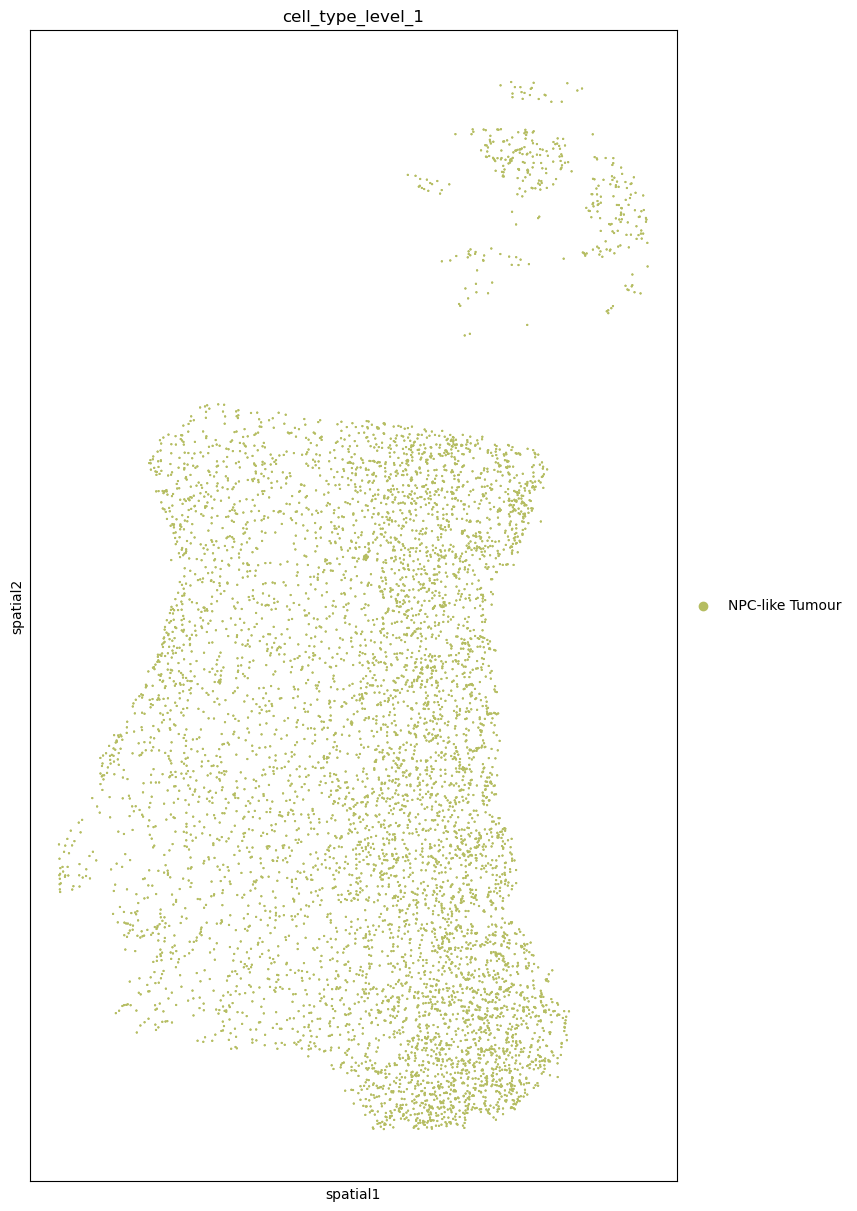

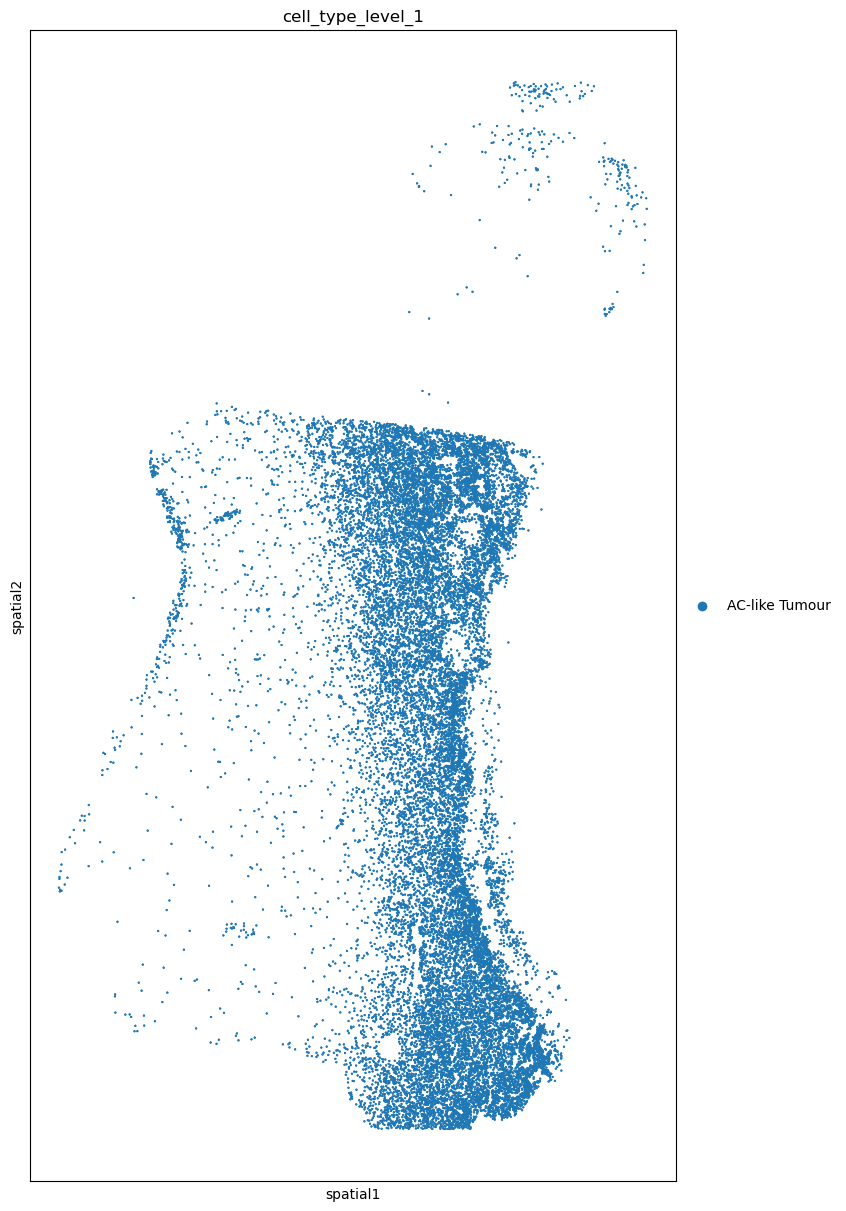

In [8]:
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        'cell_type_level_1'],
    groups=["Oligodendrocytes"],
    wspace=0.4,
    figsize=(10, 12)
)
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        'cell_type_level_1'],
    groups=[ 'NPC-like Tumour'],
    wspace=0.4,
    figsize=(10, 12)
)
sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color=[
        'cell_type_level_1'],
    groups=['AC-like Tumour'],
    wspace=0.4,
    figsize=(10, 12)
)